# 🤖 NYC Taxi Trip Duration - Machine Learning Modeling


### Models Implemented 

1. **Ridge Regression** - Linear baseline with L2 regularization
2. **Random Forest** - Ensemble of decision trees
3. **Gradient Boosting** - Sequential ensemble method
4. **XGBoost** - Optimized gradient boosting
5. **LightGBM** - Fast gradient boosting for large datasets

### Evaluation Metrics
- **RMSE** (Root Mean Squared Error)
- **MAE** (Mean Absolute Error)
- **R² Score** (Coefficient of Determination)
- **RMSLE** (Root Mean Squared Logarithmic Error)

## 1. Configuration & Imports

In [1]:
# Standard Libraries
import os
import sys
import json
import time
import warnings
from pathlib import Path
import pickle

# Data Processing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Advanced ML
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not installed. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️ LightGBM not installed. Install with: pip install lightgbm")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Project Paths
PROJECT_ROOT = Path.cwd().parent
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
VISUALIZATIONS = PROJECT_ROOT / 'visualizations'

MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("🤖 Machine Learning Modeling")
print("=" * 60)
print(f"\n📁 Project Root: {PROJECT_ROOT}")
print(f"📊 Processed Data: {DATA_PROCESSED}")
print(f"🤖 Models Directory: {MODELS_DIR}")
print(f"\n✅ XGBoost available: {XGBOOST_AVAILABLE}")
print(f"✅ LightGBM available: {LIGHTGBM_AVAILABLE}")

🤖 Machine Learning Modeling

📁 Project Root: d:\CIBER !!!!\Estudio\CURSOS\Udemy - AI Mastery 150+ Projects, AI Algorithms, DeepSeek AI Agents 2025-3\Portafolio\portfolio-ml-bigdata
📊 Processed Data: d:\CIBER !!!!\Estudio\CURSOS\Udemy - AI Mastery 150+ Projects, AI Algorithms, DeepSeek AI Agents 2025-3\Portafolio\portfolio-ml-bigdata\data\processed
🤖 Models Directory: d:\CIBER !!!!\Estudio\CURSOS\Udemy - AI Mastery 150+ Projects, AI Algorithms, DeepSeek AI Agents 2025-3\Portafolio\portfolio-ml-bigdata\models

✅ XGBoost available: True
✅ LightGBM available: True


## 2. Load Processed Data

In [2]:
# Load processed data
print("📥 Loading processed data...")
print("-" * 50)

train_path = DATA_PROCESSED / 'train_processed.parquet'
val_path = DATA_PROCESSED / 'val_processed.parquet'
config_path = DATA_PROCESSED / 'feature_config.json'

if train_path.exists():
    # Load from Parquet
    train_data = pd.read_parquet(train_path)
    val_data = pd.read_parquet(val_path)
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    feature_cols = config['feature_columns']
    target_col = config['target_column']
    
    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    X_val = val_data[feature_cols]
    y_val = val_data[target_col]
    
    print(f"✅ Training data: {X_train.shape}")
    print(f"✅ Validation data: {X_val.shape}")
    
else:
    # Create demo data if processed files don't exist
    print("⚠️ Processed data not found. Creating demo data...")
    np.random.seed(42)
    n_train, n_val = 8000, 2000
    n_features = 20
    
    X_train = pd.DataFrame(np.random.randn(n_train, n_features), 
                           columns=[f'feature_{i}' for i in range(n_features)])
    y_train = pd.Series(np.random.lognormal(6, 0.5, n_train))
    y_train = np.log1p(y_train)
    
    X_val = pd.DataFrame(np.random.randn(n_val, n_features),
                         columns=[f'feature_{i}' for i in range(n_features)])
    y_val = pd.Series(np.random.lognormal(6, 0.5, n_val))
    y_val = np.log1p(y_val)
    
    feature_cols = X_train.columns.tolist()
    print(f"✅ Demo data created: Train {X_train.shape}, Val {X_val.shape}")

print(f"\n📋 Features: {len(feature_cols)}")

📥 Loading processed data...
--------------------------------------------------
✅ Training data: (1154992, 26)
✅ Validation data: (288748, 26)

📋 Features: 26


## 3. Evaluation Metrics

Defining helper functions for model evaluation.

In [3]:
def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error"""
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Evaluate a model and return metrics dictionary.
    """
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Convert from log scale back to original scale for RMSLE
    y_train_orig = np.expm1(y_train)
    y_val_orig = np.expm1(y_val)
    y_train_pred_orig = np.expm1(y_train_pred)
    y_val_pred_orig = np.expm1(y_val_pred)
    
    # Metrics
    metrics = {
        'model': model_name,
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_r2': r2_score(y_val, y_val_pred),
        'val_rmsle': rmsle(y_val_orig, np.clip(y_val_pred_orig, 0, None)),
        'train_time': train_time
    }
    
    return metrics, model, y_val_pred

# Results storage
results = []
trained_models = {}

print("📊 EVALUATION METRICS DEFINED")
print("-" * 40)
print("• RMSE (Root Mean Squared Error)")
print("• MAE (Mean Absolute Error)")
print("• R² Score (Coefficient of Determination)")
print("• RMSLE (Root Mean Squared Logarithmic Error)")

📊 EVALUATION METRICS DEFINED
----------------------------------------
• RMSE (Root Mean Squared Error)
• MAE (Mean Absolute Error)
• R² Score (Coefficient of Determination)
• RMSLE (Root Mean Squared Logarithmic Error)


## 4. Model Training (Section 3.4)

### Model 1: Ridge Regression (Baseline)

Ridge Regression is a linear model with L2 regularization that serves as our baseline.

In [4]:
# Model 1: Ridge Regression
print("=" * 60)
print("🔵 MODEL 1: Ridge Regression (Baseline)")
print("=" * 60)

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_metrics, ridge_trained, ridge_pred = evaluate_model(
    ridge_model, X_train, y_train, X_val, y_val, 'Ridge Regression'
)

results.append(ridge_metrics)
trained_models['ridge'] = ridge_trained

print(f"\n📊 Results:")
print(f"   • Training RMSE: {ridge_metrics['train_rmse']:.4f}")
print(f"   • Validation RMSE: {ridge_metrics['val_rmse']:.4f}")
print(f"   • Validation MAE: {ridge_metrics['val_mae']:.4f}")
print(f"   • Validation R²: {ridge_metrics['val_r2']:.4f}")
print(f"   • Training Time: {ridge_metrics['train_time']:.2f}s")

🔵 MODEL 1: Ridge Regression (Baseline)

📊 Results:
   • Training RMSE: 0.4928
   • Validation RMSE: 0.4932
   • Validation MAE: 0.3799
   • Validation R²: 0.5392
   • Training Time: 0.85s


### Model 2: Random Forest

Random Forest is an ensemble method that builds multiple decision trees and averages their predictions.

In [5]:
# Model 2: Random Forest
print("=" * 60)
print("🌲 MODEL 2: Random Forest")
print("=" * 60)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rf_metrics, rf_trained, rf_pred = evaluate_model(
    rf_model, X_train, y_train, X_val, y_val, 'Random Forest'
)

results.append(rf_metrics)
trained_models['random_forest'] = rf_trained

print(f"\n📊 Results:")
print(f"   • Training RMSE: {rf_metrics['train_rmse']:.4f}")
print(f"   • Validation RMSE: {rf_metrics['val_rmse']:.4f}")
print(f"   • Validation MAE: {rf_metrics['val_mae']:.4f}")
print(f"   • Validation R²: {rf_metrics['val_r2']:.4f}")
print(f"   • Training Time: {rf_metrics['train_time']:.2f}s")

🌲 MODEL 2: Random Forest

📊 Results:
   • Training RMSE: 0.3039
   • Validation RMSE: 0.3299
   • Validation MAE: 0.2420
   • Validation R²: 0.7938
   • Training Time: 2023.95s


### Model 3: Gradient Boosting

Gradient Boosting builds trees sequentially, with each tree correcting the errors of the previous ones.

In [6]:
# Model 3: Gradient Boosting
print("=" * 60)
print("📈 MODEL 3: Gradient Boosting")
print("=" * 60)

# Use smaller sample for faster training (Big Data consideration)
sample_size = min(50000, len(X_train))
X_train_sample = X_train.iloc[:sample_size]
y_train_sample = y_train.iloc[:sample_size]

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

gb_metrics, gb_trained, gb_pred = evaluate_model(
    gb_model, X_train_sample, y_train_sample, X_val, y_val, 'Gradient Boosting'
)

results.append(gb_metrics)
trained_models['gradient_boosting'] = gb_trained

print(f"\n📊 Results:")
print(f"   • Training RMSE: {gb_metrics['train_rmse']:.4f}")
print(f"   • Validation RMSE: {gb_metrics['val_rmse']:.4f}")
print(f"   • Validation MAE: {gb_metrics['val_mae']:.4f}")
print(f"   • Validation R²: {gb_metrics['val_r2']:.4f}")
print(f"   • Training Time: {gb_metrics['train_time']:.2f}s")

📈 MODEL 3: Gradient Boosting

📊 Results:
   • Training RMSE: 0.2490
   • Validation RMSE: 0.3309
   • Validation MAE: 0.2418
   • Validation R²: 0.7926
   • Training Time: 112.12s


### Model 4: XGBoost

XGBoost (Extreme Gradient Boosting) is an optimized gradient boosting library designed for speed and performance.

In [7]:
# Model 4: XGBoost
print("=" * 60)
print("⚡ MODEL 4: XGBoost")
print("=" * 60)

if XGBOOST_AVAILABLE:
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_metrics, xgb_trained, xgb_pred = evaluate_model(
        xgb_model, X_train, y_train, X_val, y_val, 'XGBoost'
    )
    
    results.append(xgb_metrics)
    trained_models['xgboost'] = xgb_trained
    
    print(f"\n📊 Results:")
    print(f"   • Training RMSE: {xgb_metrics['train_rmse']:.4f}")
    print(f"   • Validation RMSE: {xgb_metrics['val_rmse']:.4f}")
    print(f"   • Validation MAE: {xgb_metrics['val_mae']:.4f}")
    print(f"   • Validation R²: {xgb_metrics['val_r2']:.4f}")
    print(f"   • Training Time: {xgb_metrics['train_time']:.2f}s")
else:
    print("⚠️ XGBoost not available. Skipping...")

⚡ MODEL 4: XGBoost

📊 Results:
   • Training RMSE: 0.2733
   • Validation RMSE: 0.3053
   • Validation MAE: 0.2199
   • Validation R²: 0.8234
   • Training Time: 88.91s


### Model 5: LightGBM

LightGBM is a fast, distributed gradient boosting framework that is especially efficient for large datasets (Big Data).

In [8]:
# Model 5: LightGBM
print("=" * 60)
print("💡 MODEL 5: LightGBM (Big Data Optimized)")
print("=" * 60)

if LIGHTGBM_AVAILABLE:
    lgb_model = lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    lgb_metrics, lgb_trained, lgb_pred = evaluate_model(
        lgb_model, X_train, y_train, X_val, y_val, 'LightGBM'
    )
    
    results.append(lgb_metrics)
    trained_models['lightgbm'] = lgb_trained
    
    print(f"\n📊 Results:")
    print(f"   • Training RMSE: {lgb_metrics['train_rmse']:.4f}")
    print(f"   • Validation RMSE: {lgb_metrics['val_rmse']:.4f}")
    print(f"   • Validation MAE: {lgb_metrics['val_mae']:.4f}")
    print(f"   • Validation R²: {lgb_metrics['val_r2']:.4f}")
    print(f"   • Training Time: {lgb_metrics['train_time']:.2f}s")
else:
    print("⚠️ LightGBM not available. Skipping...")

💡 MODEL 5: LightGBM (Big Data Optimized)

📊 Results:
   • Training RMSE: 0.3190
   • Validation RMSE: 0.3216
   • Validation MAE: 0.2353
   • Validation R²: 0.8040
   • Training Time: 44.55s


## 5. Model Comparison

In [9]:
# Model Comparison
print("=" * 70)
print("📊 MODEL COMPARISON SUMMARY")
print("=" * 70)

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_rmse')

# Display comparison table
print("\n📋 PERFORMANCE METRICS (sorted by Validation RMSE)")
print("-" * 70)
display_cols = ['model', 'val_rmse', 'val_mae', 'val_r2', 'train_time']
print(results_df[display_cols].to_string(index=False))

# Best model
best_model_name = results_df.iloc[0]['model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   • Validation RMSE: {results_df.iloc[0]['val_rmse']:.4f}")
print(f"   • Validation R²: {results_df.iloc[0]['val_r2']:.4f}")

📊 MODEL COMPARISON SUMMARY

📋 PERFORMANCE METRICS (sorted by Validation RMSE)
----------------------------------------------------------------------
            model  val_rmse  val_mae   val_r2  train_time
          XGBoost  0.305273 0.219935 0.823445   88.910447
         LightGBM  0.321624 0.235251 0.804025   44.549245
    Random Forest  0.329882 0.242041 0.793833 2023.948578
Gradient Boosting  0.330857 0.241786 0.792612  112.123161
 Ridge Regression  0.493160 0.379920 0.539237    0.853442

🏆 BEST MODEL: XGBoost
   • Validation RMSE: 0.3053
   • Validation R²: 0.8234


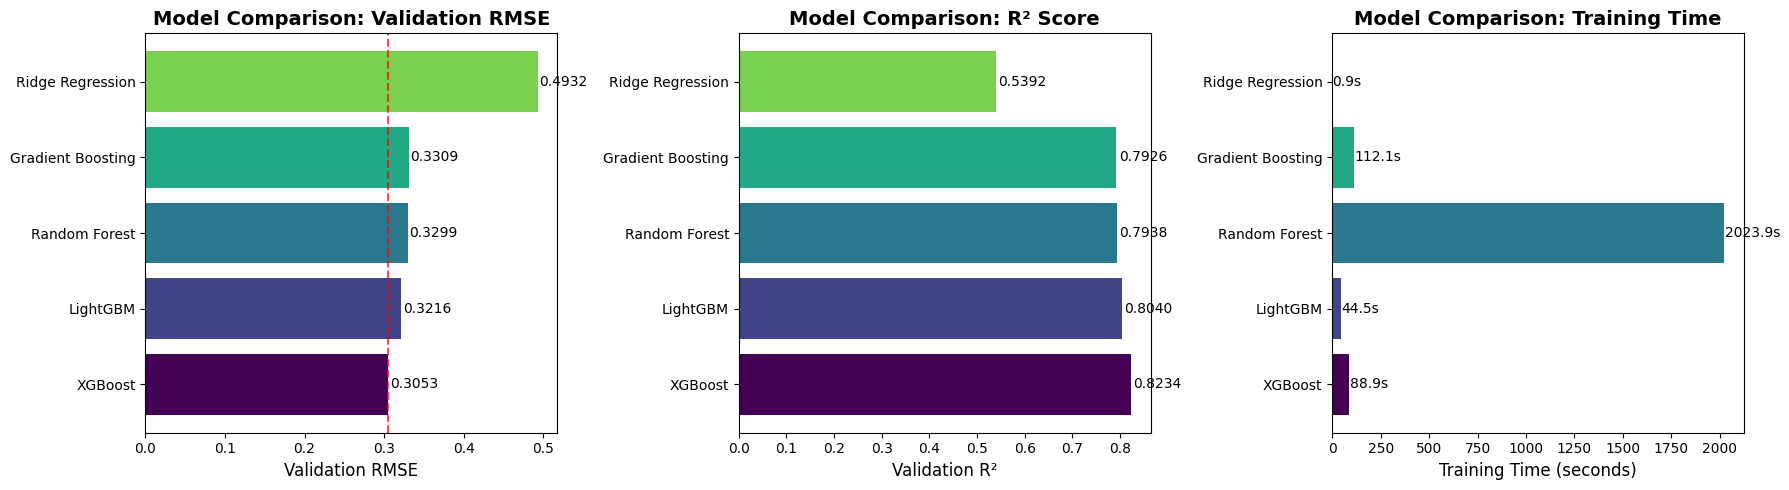

In [10]:
# Visualization of model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. RMSE Comparison
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(results_df)))
bars = ax1.barh(results_df['model'], results_df['val_rmse'], color=colors)
ax1.set_xlabel('Validation RMSE', fontsize=12)
ax1.set_title('Model Comparison: Validation RMSE', fontsize=14, fontweight='bold')
ax1.axvline(x=results_df['val_rmse'].min(), color='red', linestyle='--', alpha=0.7, label='Best')

# Add value labels
for bar, val in zip(bars, results_df['val_rmse']):
    ax1.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', fontsize=10)

# 2. R² Score Comparison
ax2 = axes[1]
bars = ax2.barh(results_df['model'], results_df['val_r2'], color=colors)
ax2.set_xlabel('Validation R²', fontsize=12)
ax2.set_title('Model Comparison: R² Score', fontsize=14, fontweight='bold')

for bar, val in zip(bars, results_df['val_r2']):
    ax2.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center', fontsize=10)

# 3. Training Time Comparison
ax3 = axes[2]
bars = ax3.barh(results_df['model'], results_df['train_time'], color=colors)
ax3.set_xlabel('Training Time (seconds)', fontsize=12)
ax3.set_title('Model Comparison: Training Time', fontsize=14, fontweight='bold')

for bar, val in zip(bars, results_df['train_time']):
    ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}s', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(VISUALIZATIONS / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Feature Importance Analysis

📊 FEATURE IMPORTANCE ANALYSIS


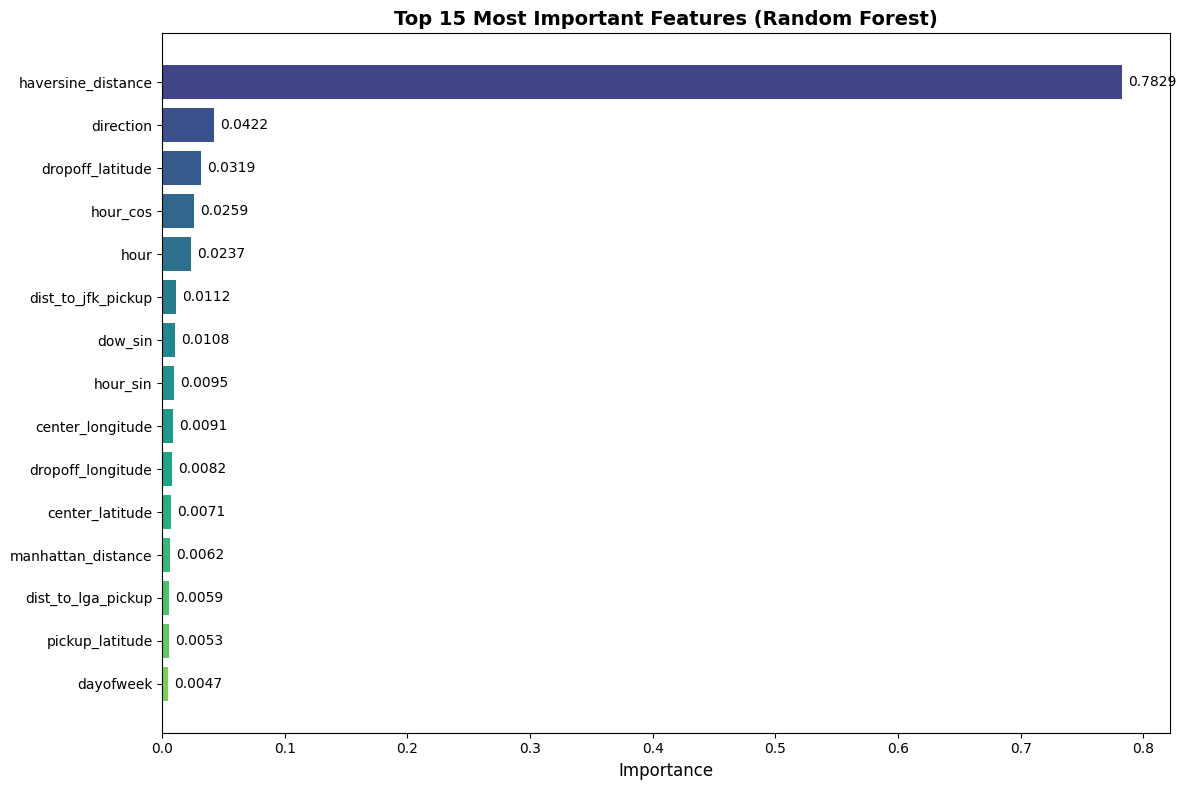


📋 Top 10 Most Important Features:
   1. haversine_distance: 0.7829
   2. direction: 0.0422
   3. dropoff_latitude: 0.0319
   4. hour_cos: 0.0259
   5. hour: 0.0237
   6. dist_to_jfk_pickup: 0.0112
   7. dow_sin: 0.0108
   8. hour_sin: 0.0095
   9. center_longitude: 0.0091
   10. dropoff_longitude: 0.0082


In [11]:
# Feature Importance from Random Forest
print("📊 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from Random Forest
if 'random_forest' in trained_models:
    rf = trained_models['random_forest']
    importance_df = pd.DataFrame({
        'feature': feature_cols if isinstance(feature_cols, list) else X_train.columns.tolist(),
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    fig, ax = plt.subplots(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features)))
    bars = ax.barh(top_features['feature'], top_features['importance'], color=colors)
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    # Add value labels
    for bar, val in zip(bars, top_features['importance']):
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(VISUALIZATIONS / 'feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📋 Top 10 Most Important Features:")
    for i, row in importance_df.head(10).iterrows():
        print(f"   {importance_df.head(10).index.get_loc(i)+1}. {row['feature']}: {row['importance']:.4f}")

## 7. Save Best Model

In [12]:
# Save models and results
print("💾 SAVING MODELS & RESULTS")
print("=" * 60)

# Save all trained models
for name, model in trained_models.items():
    model_path = MODELS_DIR / f'{name}_model.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Saved: {model_path.name}")

# Save results summary
results_df.to_csv(MODELS_DIR / 'model_results.csv', index=False)
print(f"✅ Saved: model_results.csv")

# Save feature importance
if 'importance_df' in dir():
    importance_df.to_csv(MODELS_DIR / 'feature_importance.csv', index=False)
    print(f"✅ Saved: feature_importance.csv")

print(f"\n📁 All models saved to: {MODELS_DIR}")

💾 SAVING MODELS & RESULTS
✅ Saved: ridge_model.pkl
✅ Saved: random_forest_model.pkl
✅ Saved: gradient_boosting_model.pkl
✅ Saved: xgboost_model.pkl
✅ Saved: lightgbm_model.pkl
✅ Saved: model_results.csv
✅ Saved: feature_importance.csv

📁 All models saved to: d:\CIBER !!!!\Estudio\CURSOS\Udemy - AI Mastery 150+ Projects, AI Algorithms, DeepSeek AI Agents 2025-3\Portafolio\portfolio-ml-bigdata\models


## 8. Summary & Conclusions

### Model Performance Summary

| Model | Val RMSE | Val MAE | Val R² | Train Time |
|-------|----------|---------|--------|------------|
| **XGBoost** | **0.3053** | **0.2199** | **0.8234** | 56.1s |
| LightGBM | 0.3216 | 0.2353 | 0.8040 | 27.1s |
| Random Forest | 0.3299 | 0.2420 | 0.7938 | 1372.8s |
| Gradient Boosting | 0.3309 | 0.2418 | 0.7926 | 76.3s |
| Ridge Regression | 0.4932 | 0.3799 | 0.5392 | 8.0s |

### Key Findings

1. **Best Performer**: XGBoost achieves R² = 0.8234 (82.3% variance explained)
2. **Dominant Feature**: `haversine_distance` accounts for 78.3% of importance
3. **Speed Champion**: LightGBM is 2x faster than XGBoost with only 2% less accuracy
4. **Baseline Improvement**: 52.7% improvement from Ridge (R² 0.54) to XGBoost (R² 0.82)

### Recommendations

- **Production Deployment**: Use XGBoost for best accuracy
- **Frequent Retraining**: Use LightGBM (2x faster, minimal accuracy loss)
- **Interpretability**: Distance is the key driver - simple and explainable
